In [4]:
!pip install jax jaxlib

In [6]:
!pip install optax


In [7]:
import jax.numpy as jnp
from jax import random, grad, jit, value_and_grad
import jax
import optax
import numpy as np
import matplotlib.pyplot as plt


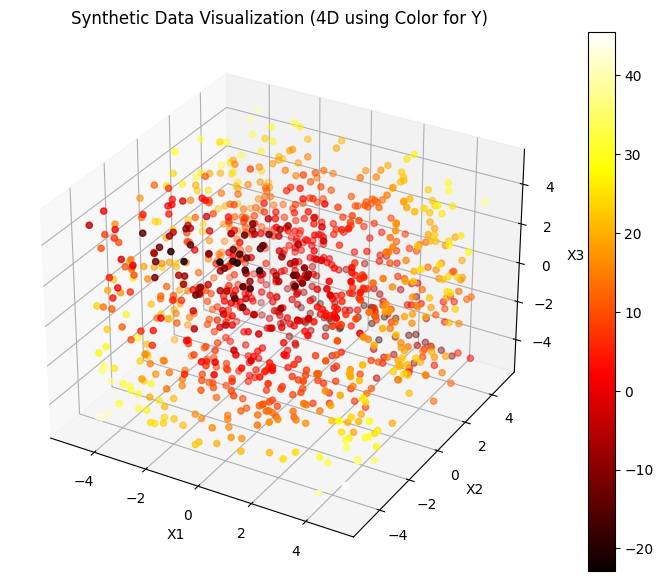

In [8]:
def generate_data(num_samples):
    rng = np.random.RandomState(0)
    x1 = rng.uniform(-5, 5, num_samples)
    x2 = rng.uniform(-5, 5, num_samples)
    x3 = rng.uniform(-5, 5, num_samples)
    y = x1**2 + x2 * x3 + np.sin(x1 * x2)
    X = np.stack([x1, x2, x3], axis=1)
    return X, y

X, y = generate_data(1000)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='hot')
fig.colorbar(p)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.title('Synthetic Data Visualization (4D using Color for Y)')
plt.show()


In [9]:
def init_network_params(layer_sizes, rng_key):
    keys = random.split(rng_key, len(layer_sizes))
    return [(random.normal(k, (m, n)), random.normal(k, (n,)))
            for k, m, n in zip(keys, layer_sizes[:-1], layer_sizes[1:])]

def predict(params, x):
    activations = x
    for w, b in params[:-1]:
        outputs = jnp.einsum('ij,jk->ik', activations, w) + b
        activations = jnp.tanh(outputs)

    final_w, final_b = params[-1]
    y_pred = jnp.einsum('ij,jk->ik', activations, final_w) + final_b
    return y_pred

layer_sizes = [3, 64, 64, 1]
rng_key = random.PRNGKey(0)
params = init_network_params(layer_sizes, rng_key)


In [10]:
import optax

def mse_loss(params, x, y):
    y_pred = predict(params, x)
    return jnp.mean((y_pred - y) ** 2)

# Initialize optimizer
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

@jit
def update(params, opt_state, x, y):
    """Update step for parameters and optimizer state."""
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss



In [11]:
epochs = 100
for epoch in range(epochs):
    params, opt_state, loss = update(params, opt_state, X, y.reshape(-1, 1))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')


Epoch 0, Loss: 284.9243469238281
Epoch 10, Loss: 103.39681243896484
Epoch 20, Loss: 64.0230941772461
Epoch 30, Loss: 42.972049713134766
Epoch 40, Loss: 29.93071937561035
Epoch 50, Loss: 22.17987823486328
Epoch 60, Loss: 16.801952362060547
Epoch 70, Loss: 12.942281723022461
Epoch 80, Loss: 10.21810245513916
Epoch 90, Loss: 8.195293426513672


Epoch 0, Loss: 6.662938117980957
Epoch 10, Loss: 5.54434871673584
Epoch 20, Loss: 4.693281650543213
Epoch 30, Loss: 4.047669887542725
Epoch 40, Loss: 3.525141477584839
Epoch 50, Loss: 3.1060714721679688
Epoch 60, Loss: 2.7634429931640625
Epoch 70, Loss: 2.473940849304199
Epoch 80, Loss: 2.225773811340332
Epoch 90, Loss: 2.0099661350250244


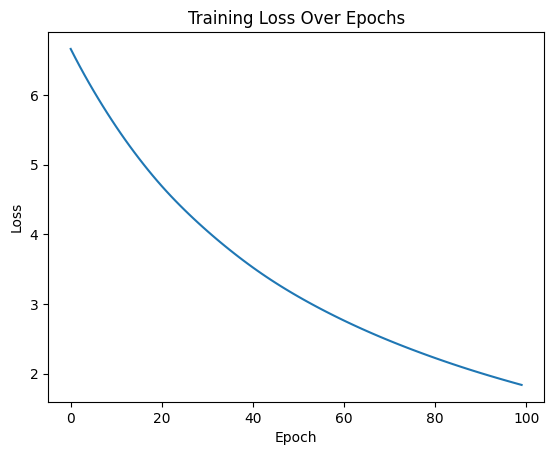

In [12]:
losses = []
for epoch in range(epochs):
    params, opt_state, loss = update(params, opt_state, X, y.reshape(-1, 1))
    losses.append(loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()


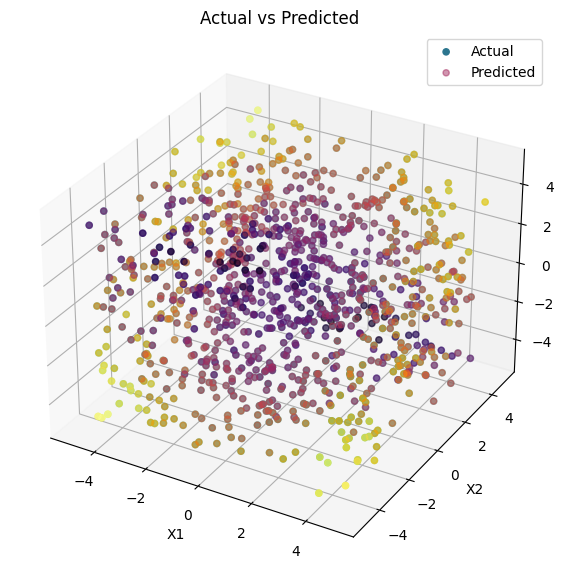

In [13]:
y_pred = predict(params, X).flatten()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='viridis', label='Actual')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred, cmap='inferno', alpha=0.5, label='Predicted')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()
